In [1]:
from PIL import Image, ImageFilter, ImageEnhance, ImageFile
import time
import shutil
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

def processor(root_data_dir, save_dir):
    
    for file in root_data_dir.iterdir():
        if file.suffix == ".jpg":
            img = Image.open(file) # print(img.size)
            # BLUR
            img = img.filter(ImageFilter.BLUR)
            # DARKEN IMG
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(0.5)
            # CROP
            width, height = img.size
            img = img.crop((0, 140, width, height)) # try 120-150
            
            img.save(save_dir/file.name)
            print("processed : ", save_dir/file.name)
    
        if str(file.stem)=="data":
                    shutil.copy(str(file), str(save_dir/file.name) )
        
    

def preprocess(root_data_dir, save_dir, delete_existing = False):
    start = time.time()
    if save_dir.exists():
        if delete_existing:
            print("Deleting existing preprocessed dir and ")
            time.sleep(1)
            shutil.rmtree(save_dir, ignore_errors=True)
            save_dir.mkdir(parents=True, exist_ok=True)
            processor(root_data_dir, save_dir)
            
        else:
            print("A preprocessed dir exists, Data might be preprocessed")
            print("Len preprocessed:", len(os.listdir(save_dir)))
    else:
        processor(root_data_dir, save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        print("Data preprocessing complete")
        print("Len preprocessed:", len(os.listdir(save_dir)))
    end = time.time()
    print(f"Total time taken : {(end-start):.2f}s")
        

        

In [2]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    ROOT_DATA_DIR = Path("/content/drive/MyDrive/research/driving_dataset")
    DATA_DIR = Path("/content/driving_dataset_preprocessed")
    ALT_DIR_PATH = Path("/content/drive/MyDrive/research/driving_dataset_preprocessed")
    EXP_DIR = Path("/content/drive/MyDrive/research/experiments")
    
    if ALT_DIR_PATH.exists():
        shutil.copytree(ALT_DIR_PATH, DATA_DIR)
except:
    ROOT_DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset")
    DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset_preprocessed")
    EXP_DIR = Path("/home/avishkar/Desktop/research/experiments")
    
preprocess(ROOT_DATA_DIR, DATA_DIR)



LABELS_PATH = DATA_DIR/"data.txt"

A preprocessed dir exists, Data might be preprocessed
Len preprocessed: 45569
Total time taken : 0.01s


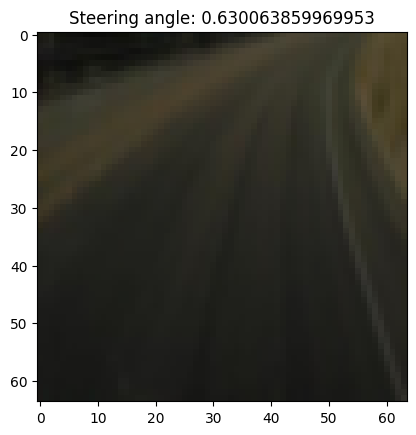

In [6]:
"""DATASET"""
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np


class DrivingDataset(Dataset):
    def __init__(self, labels_path, data_dir, transform=None):
        with open(Path(labels_path), "r") as f:
            self.labels = f.readlines()
            f.close()
        self.data_dir = Path(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index) :
        img_path, label = self.labels[index].split()
        label=float(label)*np.pi/180
        img = Image.open(self.data_dir/img_path)

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(5),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

BATCH_SIZE = 16
NUM_WORKERS = 2

dataset = DrivingDataset(labels_path=LABELS_PATH, data_dir=DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = int(len(dataset)-train_size)
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    label = labels[0]
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Steering angle: {label.item()}")
    # plt.axis('off')
    plt.show()
    break

In [7]:
"""MODEL"""
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class ResNet50SteeringPred(nn.Module):
    def __init__(self, config):
        super(ResNet50SteeringPred, self).__init__()
        self.ResNet = models.resnet50(pretrained=True, progress=True) # Output dim = 1000
        
        self.fc1 = nn.Linear(in_features =1000, out_features = 256, bias=True)
        self.fc2 = nn.Linear(in_features = 256, out_features = 64, bias=True)
        self.fc3 = nn.Linear(in_features = 64, out_features = 1, bias=True)
        
    def forward(self, x):
        image = self.ResNet(x)
        # input size = (1,3,32,32)-(Batches, Channels, Height, Width)
        # output size = (1, 1000)-(Batches, Feature)
        image = F.relu(self.fc1(image))
        # input size = (1,1000)-(batches, features)
        # output size = (1,512)-(batches, features)
        image = F.relu(self.fc2(image))
        # input size = (1,512)-(batches, features)
        # output size = (1,256)-(batches, features)
        angle = self.fc3(image)
        # input size = (1,256)-(batches, features)
        # output size = (1,64)-(batches, features)
        # angle = self.fc4(image)
        # input size = (1,64)-(batches, features
        # output size = (1,1)-(batches, features)
        return angle
        

In [8]:
"""UTILS"""
import json
from pathlib import Path
import torch

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, train_accuracies,test_accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "train_accuracies":train_accuracies,
        "test_accuracies":test_accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    train_accuracies=data["train_accuracies"]
    test_accuracies=data["test_accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, train_accuracies,test_accuracies, epoch
    
    

In [9]:
config ={
        
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "exp_name":"vit_mnist_40_epoch",
        "num_epoch":40
    }

import time
from tqdm import tqdm

class Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, test_loader, num_epochs):
        train_losses, test_losses, train_accuracies, test_accuracies = [], [] , [], []
        start = time.time()
        for epoch in range(num_epochs):
            ep_start = time.time()
            train_loss, train_accuracy = self.train_epoch(train_loader)
            test_loss, test_accuracy = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            ep_end = time.time()
            print(f"Epoch: {epoch}/{num_epochs}, Time : {(ep_end-ep_start):.2f}s")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
            print(f"Train Accuracy : {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
            
        save_experiment(self.model, num_epochs, config, train_losses, test_losses, train_accuracies,test_accuracies, EXP_DIR)
        end = time.time()
        print(f"Total Training Time : {(end-start):.2f}s")
            
    def train_epoch(self, train_loader):
        self.model.train()
        correct = 0
        running_train_loss = 0
        for i, (imgs, labels) in enumerate(tqdm(train_loader, position=0, leave=True)):
            imgs = imgs.float().to(self.device)
            labels = labels.float().to(self.device)

            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            running_train_loss += loss.item() * len(imgs)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            predictions = torch.argmax(predictions, dim=1)
            correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(train_loader.dataset)
        train_loss = running_train_loss / len(train_loader.dataset)
        return train_loss, accuracy

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        running_test_loss = 0
        for i, (imgs, labels) in enumerate(tqdm(test_loader, position=0, leave=True)):
            imgs = imgs.to(self.device)
            labels = labels.type(torch.uint8).to(self.device)

            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            running_test_loss += loss.item() * len(imgs)

            predictions = torch.argmax(predictions, dim=1)
            correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        test_loss = running_test_loss / len(test_loader.dataset)
        return test_loss, accuracy
            
def main():
    model = ResNet50SteeringPred(config)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    trainer = Trainer(model, criterion, optimizer, config["device"])
    trainer.train(train_loader, test_loader, config["num_epoch"])

    

In [10]:
main()

/home/avishkar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avishkar/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/2271 [00:00<?, ?it/s]/home/avishkar/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

Epoch: 0/40, Time : 1010.56s
Train Loss: 0.2898, Test Loss: 2194.5311
Train Accuracy : 0.0447, Test Accuracy: 0.9416


  2%|▏         | 41/2271 [00:19<17:42,  2.10it/s]


KeyboardInterrupt: 

In [ ]:
# """Visualize Losses"""
# 
import matplotlib.pyplot as plt
 
model = ResNet50SteeringPred(config)
_, train_losses, test_losses, train_accuracies, test_accuracies,_ = load_experiment(model, config["exp_name"], EXP_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accuracies, label="Training Accuracy")
ax2.plot(test_accuracies, label="Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")